# Analysis and Plotting in NetPyNE

## Install NEURON and NetPyNE

In [ ]:
!pip install neuron
!pip install netpyne

     |████████████████████████████████| 12.6MB 220kB/s 
     |████████████████████████████████| 317kB 6.7MB/s 


## Clone the NetPyNE GUI workspace and compile the mod files

In [ ]:
!git clone https://github.com/Neurosim-lab/netpyne_workspace

Cloning into 'netpyne_workspace'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 423 (delta 86), reused 108 (delta 46), pack-reused 272
Receiving objects: 100% (423/423), 79.12 MiB | 33.27 MiB/s, done.
Resolving deltas: 100% (235/235), done.


Now we will change into that directory and compile the mod files.

In [ ]:
cd netpyne_workspace

/content/netpyne_workspace


In [ ]:
!nrnivmodl mod

/content/netpyne_workspace
Mod files: "mod/ar.mod" "mod/ar_traub.mod" "mod/beforestep_py.mod" "mod/cadad.mod" "mod/cad.mod" "mod/cadyn.mod" "mod/cagk.mod" "mod/cal_mh.mod" "mod/cal_mig.mod" "mod/ca.mod" "mod/canin.mod" "mod/can_mig.mod" "mod/catcb.mod" "mod/cat_mig.mod" "mod/cat.mod" "mod/cat_traub.mod" "mod/dipole.mod" "mod/dipole_pp.mod" "mod/gabab.mod" "mod/h_BS.mod" "mod/HCN1.mod" "mod/hh2.mod" "mod/hh3.mod" "mod/h_harnett.mod" "mod/hin.mod" "mod/h_kole.mod" "mod/h_migliore.mod" "mod/ican_sidi.mod" "mod/IC.mod" "mod/IKsin.mod" "mod/kap_BS.mod" "mod/kapcb.mod" "mod/kapin.mod" "mod/kBK.mod" "mod/kca.mod" "mod/kctin.mod" "mod/kdmc_BS.mod" "mod/kdr_BS.mod" "mod/kdrin.mod" "mod/km.mod" "mod/lfp.mod" "mod/mea.mod" "mod/nafx.mod" "mod/nap_sidi.mod" "mod/nax_BS.mod" "mod/savedist.mod" "mod/vecevent.mod" "mod/vecstim.mod"

Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.c
x86_64-linux-gnu-gcc -O2   -I.   -I/usr/local/lib/python3.7/dist-packages/neuron/.data/include 

## Load a tutorial

We will be modifying `gut_tut3` and running that to explore analyses and plotting.


In [ ]:
from netpyne import specs


#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.sizeX = 100 # x-dimension (horizontal length) size in um
netParams.sizeY = 500 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 100 # z-dimension (horizontal length) size in um
netParams.propVelocity = 100.0 # propagation velocity (um/ms)
netParams.probLengthConst = 150.0 # length constant for conn probability (um)

#------------------------------------------------------------------------------
## Cell parameters
netParams.loadCellParams(label='E', fileName='cells/CSTR_cellParams.json')
netParams.importCellParams(label='I', fileName='cells/FScell.hoc', cellName='FScell')


#------------------------------------------------------------------------------
## Population parameters
netParams.popParams['E2'] = {'cellType': 'E', 'numCells': 10, 'yRange': [50,150]}
netParams.popParams['I2'] = {'cellType': 'I', 'numCells': 10, 'yRange': [50,150]}
netParams.popParams['E4'] = {'cellType': 'E', 'numCells': 10, 'yRange': [150,300]}
netParams.popParams['I4'] = {'cellType': 'I', 'numCells': 10, 'yRange': [150,300]}
netParams.popParams['E5'] = {'cellType': 'E', 'numCells': 10, 'ynormRange': [0.6,1.0]}
netParams.popParams['I5'] = {'cellType': 'I', 'numCells': 10, 'ynormRange': [0.6,1.0]}

#------------------------------------------------------------------------------
## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

#------------------------------------------------------------------------------
# Stimulation parameters
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 20, 'noise': 0.3}
netParams.stimTargetParams['bkg->E'] = {'source': 'bkg', 'conds': {'cellType': ['E']}, 'weight': 0.02, 'sec': 'soma', 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}
netParams.stimTargetParams['bkg->I'] = {'source': 'bkg', 'conds': {'cellType': ['I']}, 'weight': 0.004, 'sec': 'soma', 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}

#------------------------------------------------------------------------------
# Cell connectivity rules
netParams.connParams['E->all'] = {
  'preConds': {'cellType': 'E'}, 'postConds': {'y': [50,500]},  #  E -> all (100-1000 um)
  'probability': 0.1,                  # probability of connection
  'weight': '0.04*post_ynorm',         # synaptic weight 
  'delay': 'dist_3D/propVelocity',      # transmission delay (ms) 
  'synMech': 'exc'}                     # synaptic mechanism 

netParams.connParams['I->E'] = {
  'preConds': {'cellType': 'I'}, 'postConds': {'pop': ['E2','E4','E5']},       #  I -> E
  'probability': '0.3*exp(-dist_3D/probLengthConst)',   # probability of connection
  'weight': 0.01,                                      # synaptic weight 
  'delay': 'dist_3D/propVelocity',                      # transmission delay (ms) 
  'sec': ['soma','Bdend'], 
  'synMech': 'inh'}                                     # synaptic mechanism 


#------------------------------------------------------------------------------
## RxD params

### constants

## Change ip3_init from 0 to 0.1 to observe multiscale effect:  
## netParams.rxdParams['constants']['ip3_init'] = 0.1
## high ip3 -> ER Ca released to Cyt -> kBK channels open -> less firing 

constants = {'ip3_init': 0.0,  # initial ip3 concentration 
            'caDiff': 0.08,  # calcium diffusion coefficient
            'ip3Diff': 1.41,  # ip3 diffusion coefficient
            'caci_init': 1e-5,  # intracellular calcium initial concentration
            'caco_init': 2.0,   # extracellular calcium initial concentration
            'gip3r': 12040 * 100,  # ip3 receptors density
            'gserca': 0.3913,  # SERCA conductance
            'gleak': 6.020,   # ER leak channel conductance
            'kserca': 0.1,  # SERCA reaction constant
            'kip3': 0.15,  # ip3 reaction constant
            'kact': 0.4,  #
            'ip3rtau': 2000,  # ip3 receptors time constant
            'fc': 0.8,  # fraction of cytosol
            'fe': 0.2,  # fraction of ER
            'margin': 20}  # extracellular volume additional margin 

netParams.rxdParams['constants'] = constants

### regions
regions = {}
regions['cyt'] = {'cells': 'all', 'secs': 'all', 'nrn_region': 'i', 'geometry': {'class': 'FractionalVolume', 'args': {'volume_fraction': constants['fc'], 'surface_fraction': 1}}}
regions['er'] = {'cells': 'all', 'secs': 'all', 'geometry': {'class': 'FractionalVolume', 'args': {'volume_fraction': constants['fe']}}}
regions['cyt_er_membrane'] = {'cells': 'all', 'secs': 'all', 'geometry': {'class': 'ScalableBorder', 'args': {'scale': 1, 'on_cell_surface': False}}}

margin = 20  # extracellular volume additional margin 
x, y, z = [0-margin, 100+margin], [-500-margin, 0+margin], [0-margin, 100+margin]
regions['ecs'] = {'extracellular': True, 'xlo': x[0], 'ylo': y[0], 'zlo': z[0], 'xhi': x[1], 'yhi': y[1], 'zhi': z[1], 'dx': 5, 'volume_fraction': 0.2, 'tortuosity': 1.6} 

netParams.rxdParams['regions'] = regions

### species 
species = {}
species['ca'] = {'regions': ['cyt', 'er', 'ecs'], 'd': constants['caDiff'], 'charge': 2,
                'initial': 'caco_init if isinstance(node,rxd.node.NodeExtracellular) else (0.0017 - caci_init * fc) / fe if node.region == er else caci_init'}
species['ip3'] = {'regions': ['cyt'], 'd': constants['ip3Diff'], 'initial': constants['ip3_init']}
netParams.rxdParams['species'] = species

### states
netParams.rxdParams['states'] = {'ip3r_gate_state': {'regions': ['cyt_er_membrane'], 'initial': 0.8}}

### reactions
minf = 'ip3[cyt] * 1000. * ca[cyt] / (ip3[cyt] + kip3) / (1000. * ca[cyt] + kact)'
h_gate = 'ip3r_gate_state[cyt_er_membrane]'
kip3 = 'gip3r * (%s * %s) ** 3' % (minf, h_gate)

mcReactions = {}
mcReactions['serca'] = {'reactant': 'ca[cyt]', 'product': 'ca[er]', 'rate_f': 'gserca / ((kserca / (1000. * ca[cyt])) ** 2 + 1)', 'membrane': 'cyt_er_membrane', 'custom_dynamics': True}
mcReactions['leak'] = {'reactant': 'ca[er]', 'product': 'ca[cyt]', 'rate_f': constants['gleak'], 'rate_b': constants['gleak'], 'membrane': 'cyt_er_membrane'}
mcReactions['ip3r'] = {'reactant': 'ca[er]', 'product': 'ca[cyt]', 'rate_f': kip3, 'rate_b': kip3, 'membrane': 'cyt_er_membrane'}
netParams.rxdParams['multicompartmentReactions'] = mcReactions

### rates
netParams.rxdParams['rates'] = {'ip3rg': {'species': h_gate, 'rate': '(1. / (1 + 1000. * ca[cyt] / (0.3)) - %s) / ip3rtau'%(h_gate)}}




#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

# Run parameters
simConfig = specs.SimConfig()       # object of class simConfig to store simulation configuration
simConfig.duration = 1.0*1e3        # Duration of the simulation, in ms
simConfig.hParams['v_init'] = -65   # set v_init to -65 mV
simConfig.dt = 0.1                  # Internal integration timestep to use
simConfig.verbose = False            # Show detailed messages 
simConfig.recordStep = 1             # Step size in ms to save data (eg. V traces, LFP, etc)
simConfig.filename = 'rxd_net'   # Set file output name


# Recording/plotting parameters
simConfig.recordTraces = {'V_soma':{'sec': 'soma','loc': 0.5,'var': 'v'},
                          'ik_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'ik'},
                          'cai_soma': {'sec': 'soma', 'loc':0.5, 'var': 'cai'},
                          'cao_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'cao'}}

simConfig.recordLFP = [[-15, y, 1.0*netParams.sizeZ] for y in range(int(netParams.sizeY/3), int(netParams.sizeY), int(netParams.sizeY/3))]

#simConfig.analysis['iplotTraces'] ={'include': [0]}
simConfig.analysis['plotTraces'] = {'include': [('E2', 0), ('I2', 0), ('E4', 0), ('I4', 0), ('E5', 0), ('I5', 0)]}

#simConfig.analysis['iplotRaster'] = {'orderBy': 'y', 'orderInverse': True, 'saveFig': True, 'figSize': (9,3)}      # Plot a raster
#simConfig.analysis['iplotLFP'] = {'includeAxon': False, 'figSize': (6,10), 'saveFig': True} 
#simConfig.analysis['iplotRxDConcentration'] = {'speciesLabel': 'ca', 'regionLabel': 'ecs'}


Now we will run the simulation.

In [ ]:
from netpyne import sim
sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

Now we can begin exploring the analyses available in NetPyNE.

## Analyses in NetPyNE

Let's take a look at the NetPyNE Package Index for analysis:
http://netpyne.org/netpyne.analysis.html#module-netpyne.analysis

In [ ]:
%matplotlib inline

In [ ]:
sa = sim.analysis

Plotting 2D representation of network cell locations and connections...


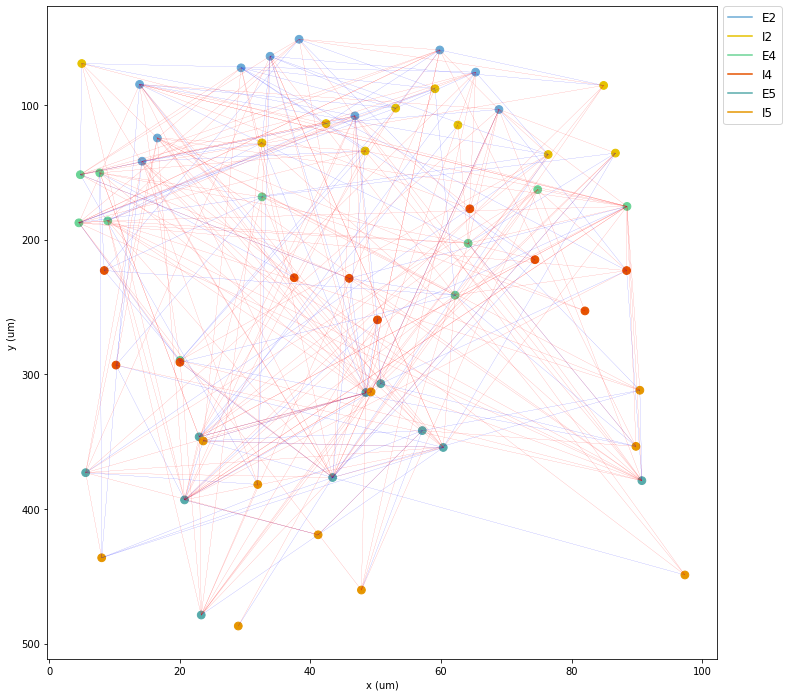

In [ ]:
sa.plot2Dnet();

In [ ]:
sa.plot2Dnet(include=['E2', 'E4', 'E5']);

In [ ]:
sa.plot2Dnet(view='xz');

In [ ]:
sa.plotConn();

In [ ]:
sa.plotConn(includePre=['E2', 'E4', 'E5'], includePost=['I2', 'I4', 'I5']);

In [ ]:
sa.plotConn(feature='numConns');

In [ ]:
sa.plotConn(groupBy='cell', feature='weight');

In [ ]:
sa.plotConn(groupBy='cell', feature='weight', orderBy='y');

In [ ]:
sa.plotRateSpectrogram();

In [ ]:
sa.plotRateSpectrogram(include=['allCells']);

In [ ]:
sa.plotRateSpectrogram(include=['allCells'], timeRange=[0, 400]);

In [ ]:
sa.plotSpikeHist();

In [ ]:
sa.plotSpikeHist(binSize=20);

In [ ]:
sa.plotSpikeHist(binSize=20);

In [ ]:
sa.plotSpikeHist(binSize=20, measure='count');

In [ ]:
sa.plotSpikeStats();

In [ ]:
foo = sa.plotSpikeStats();

In [ ]:
fig, data = sa.plotSpikeStats();

In [ ]:
!pip install pyspike

In [ ]:
sa.plotTraces();

In [ ]:
sa.plotTraces(oneFigPer='trace');

In [1]:
sa.plotTraces(oneFigPer='trace', overlay=True);

NameError: ignored

In [ ]:
sa.plotTraces(oneFigPer='trace', overlay=True, axis=False);

In [ ]:
sa.plotRaster();

In [ ]:
sa.plotRaster(orderBy='y');

In [ ]:
sa.plotRaster(orderInverse=True, popRates=True);

In [ ]:
sa.plotRaster(orderInverse=True, labels='overlay');

In [ ]:
sa.plotRaster(orderInverse=True, spikeHist='subplot');

In [ ]:
sa.plotRaster(orderInverse=True, syncLines=True);

In [ ]:
sa.plotRaster(orderInverse=True, marker='o');

In [ ]:
colors = {'E2': 'red'}

In [ ]:
colors['E4'] = 'pink'
colors['E5'] = 'orange'
colors['I2'] = 'blue'
colors['I4'] = 'purple'
colors['I5'] = 'black'

In [ ]:
sa.plotRaster(orderInverse=True, marker='o', popColors=colors);

In [ ]:
sa.plotLFP();

In [ ]:
sa.plotRxDConcentration(speciesLabel='ca', regionLabel='ecs');

In [ ]:
for species in ['ca', 'ip3']:
    for region in ['cyt', 'er', 'cyt_er_membrane', 'ecs']:
        sa.plotRxDConcentration(speciesLabel=species, regionLabel=region);

In [ ]:
sim.simData